In [ ]:
pip install librosa tensorflow scikit-learn matplotlib


In [ ]:
!pip install resampy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 11.5 MB/s eta 0:00:00


In [ ]:
import resampy
print(resampy.__version__)


0.4.3


In [ ]:
#importing necessary libraries
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import resampy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
#uploading the dataset using google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/RAVDESS Emotional speech audio'


In [ ]:
# Function to extract features from an audio file
def extract_features(file_path, max_pad_len=862):  # You can adjust max_pad_len based on your dataset
    audio, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)

    # Pad or truncate the mel-spectrogram to ensure consistent shape
    if log_mel_spectrogram.shape[1] > max_pad_len:
        log_mel_spectrogram = log_mel_spectrogram[:, :max_pad_len]
    else:
        pad_width = max_pad_len - log_mel_spectrogram.shape[1]
        log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')

    return log_mel_spectrogram

In [ ]:
# Loading the dataset and preparing labels
def load_data(data_path, max_pad_len=862):
    features = []
    labels = []
    emotions = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }

    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('.wav'):
                # Extract emotion from file name
                emotion = file.split('-')[2]
                emotion_label = emotions.get(emotion, 'unknown')

                # Extract features
                file_path = os.path.join(root, file)
                feature = extract_features(file_path, max_pad_len)
                features.append(feature)
                labels.append(emotion_label)

    return np.array(features), np.array(labels)

In [ ]:
# Load data
X, y = load_data(data_path)
X = np.expand_dims(X, axis=-1)

In [ ]:
# 3. Label encoding
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# 4. Build the CNN model
def build_model(input_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(8, activation='softmax'))  # 8 emotion categories

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = (X_train.shape[1], X_train.shape[2], 1)  # Adjust input shape based on data
model = build_model(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 860, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 430, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 428, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 214, 64)       0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 410880)            0         
                                                                 
 dense (Dense)               (None, 128)               5

In [ ]:
# 5. Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
72/72 [==============================] - 61s 840ms/step - loss: 20.8234 - accuracy: 0.2734 - val_loss: 1.5259 - val_accuracy: 0.4184
Epoch 2/20
72/72 [==============================] - 60s 839ms/step - loss: 1.3902 - accuracy: 0.4996 - val_loss: 1.1873 - val_accuracy: 0.5885
Epoch 3/20
72/72 [==============================] - 59s 825ms/step - loss: 0.9925 - accuracy: 0.6345 - val_loss: 0.7878 - val_accuracy: 0.7083
Epoch 4/20
72/72 [==============================] - 60s 827ms/step - loss: 0.7029 - accuracy: 0.7543 - val_loss: 0.6440 - val_accuracy: 0.7674
Epoch 5/20
72/72 [==============================] - 59s 826ms/step - loss: 0.5011 - accuracy: 0.8247 - val_loss: 0.6785 - val_accuracy: 0.8038
Epoch 6/20
72/72 [==============================] - 59s 822ms/step - loss: 0.3959 - accuracy: 0.8637 - val_loss: 0.4075 - val_accuracy: 0.8785
Epoch 7/20
72/72 [==============================] - 59s 816ms/step - loss: 0.3012 - accuracy: 0.8911 - val_loss: 0.3334 - val_accuracy: 0.913

In [ ]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

18/18 [==============================] - 3s 151ms/step - loss: 0.4746 - accuracy: 0.9444
Test Accuracy: 0.9444444179534912


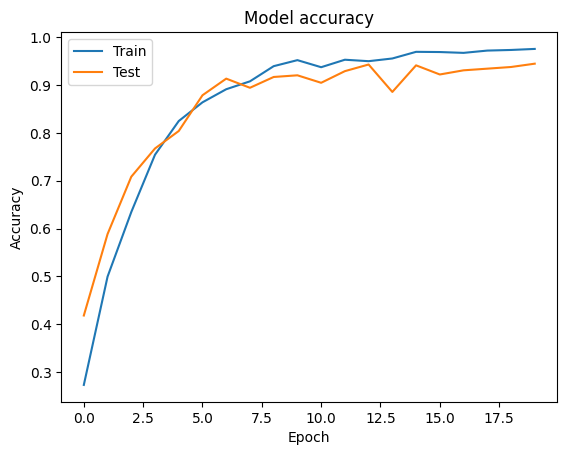

In [ ]:
# 6. Visualize the training
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

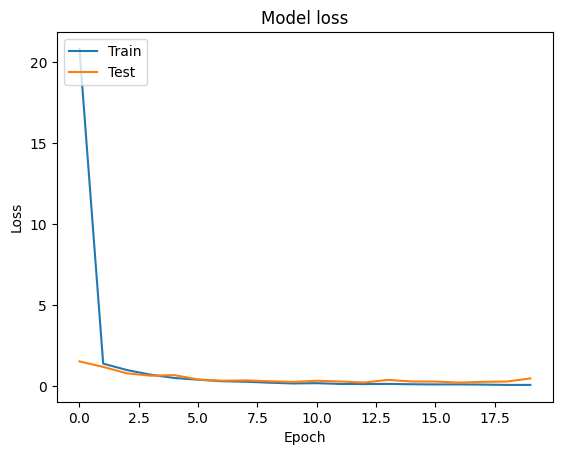

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# 7. Evaluation with confusion matrix and classification report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

18/18 [==============================] - 3s 156ms/step


In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

Confusion Matrix Accuracy: 0.9444444444444444
Precision: 0.9471064236689237
Recall: 0.9444444444444444
F1 Score: 0.9448685946047486

Classification Report:

              precision    recall  f1-score   support

       angry       0.97      0.93      0.95        81
        calm       1.00      0.97      0.98        66
     disgust       0.97      0.97      0.97        71
     fearful       0.87      0.94      0.91        72
       happy       0.87      0.94      0.91        71
     neutral       1.00      0.86      0.93        43
         sad       0.93      0.95      0.94        86
   surprised       0.98      0.95      0.96        86

    accuracy                           0.94       576
   macro avg       0.95      0.94      0.94       576
weighted avg       0.95      0.94      0.94       576



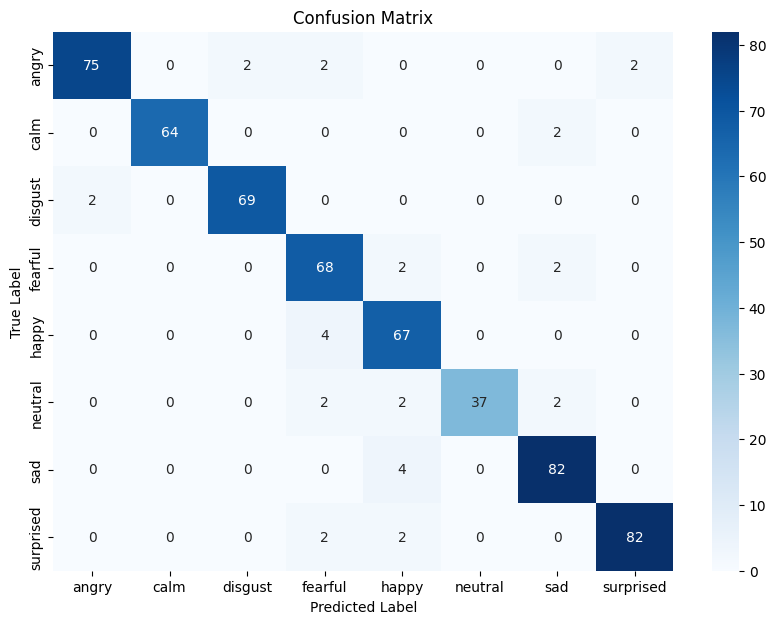

In [ ]:
print(f"Confusion Matrix Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=encoder.classes_))

# Confusion matrix plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


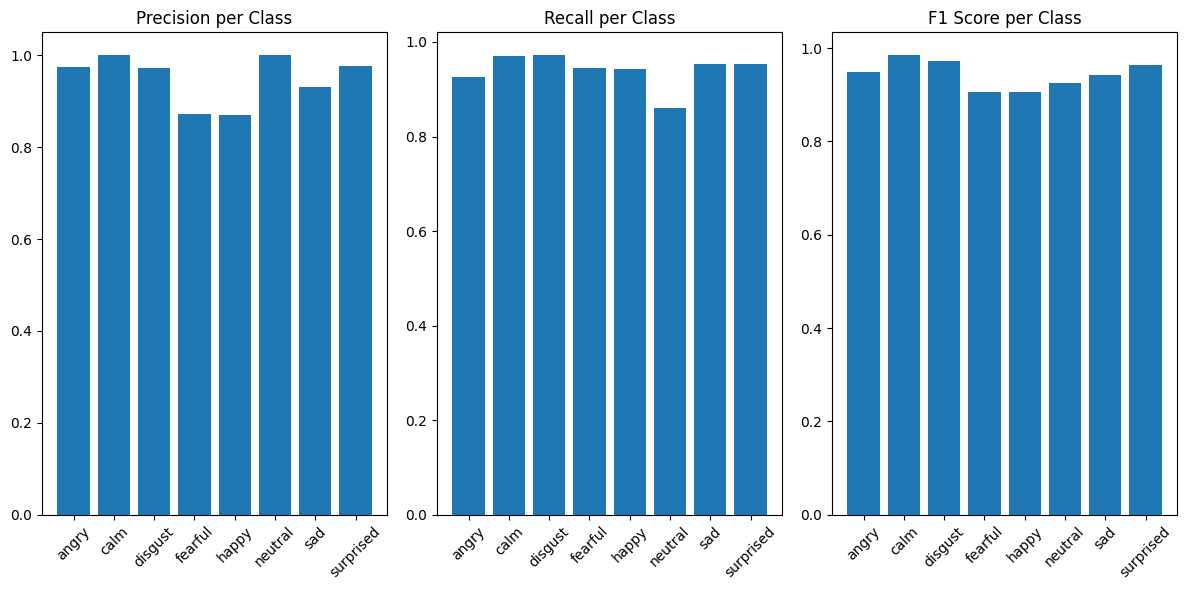

In [ ]:
# 8. Precision, Recall, F1 Score per class
from sklearn.metrics import precision_recall_fscore_support

precisions, recalls, f1s, _ = precision_recall_fscore_support(y_test, y_pred_classes)

# Plotting
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.bar(encoder.classes_, precisions)
plt.title('Precision per Class')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar(encoder.classes_, recalls)
plt.title('Recall per Class')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
plt.bar(encoder.classes_, f1s)
plt.title('F1 Score per Class')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()